# Load Packages 

In [1]:
#Install this package if needed 
#pip install matplotlib-venn

In [2]:
import pandas as pd

from random import sample
import re
import numpy as np
from math import nan, isnan

from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

from pathlib import Path  

# Creating First Dataset

In [3]:

transactions_updated = pd.read_csv("Obtained datasets/csv format/transactions_updated.csv")

#Creating a dictonray such that key is ERC numbers and value is the name of the firm
#This will be useful to get seller information
erc_name_dict = dict()
for pair in transactions_updated[["ercnbr", "name" ]].values.tolist(): erc_name_dict.update({pair[0]: pair[1]})


#Now create a new column using the dictionary using created above
prev_company_name = [] 
a = 0
for prev in transactions_updated["previous_erc_0"].values.tolist():
    if prev in erc_name_dict.keys():
        prev_company_name.append(erc_name_dict[prev])
    else: 
        a = a +1 
        prev_company_name.append(None)

#Add these values to the new column seller
transactions_updated["Seller"] = prev_company_name


#Rename the columns to be export ready
df_1 = transactions_updated[['facid', 'name', 'ercnbr',  'erc_amt', 'price_adjusted', 'previous_erc_0' , "Seller",'month_issued', 'year_issued']]
df_1 = df_1.rename(columns={"name": "Buyer", "facid": "Buyer_ID", "erc_amt": "Amount", 'price_adjusted': "Price", "ercnbr": "Current_ERC_number", "previous_erc_0": "Past_ERC_number"})


In [4]:
#Export the first datset to the folder

filepath = Path('Transaction_w_Buyer,Seller,Amount,Price,Date.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_1.to_csv(filepath)  

# Creating Second dataset

Creating the second dataset is more involved because a number of ERCs that appear in the ERC website do not appear in the transction file and vice versa. This is explained in the visualization in step 4) 

Furthermore, Object Oriented Programming is used starting step (3) to make the manipulation and coding smoother

## 1) Loading the dataframe

In [ ]:

mergedERC = pd.read_csv("Obtained datasets/csv format/mergedERC.csv")

#Some minor cleaning
mergedERC = mergedERC[mergedERC["facid"] != " CDHR 057-20E0398D-0220"]

## 2) Recording observed years for each ERC number persent in the ERC website

In [7]:
#Here a new column is added that records all the period the ERC number appears in the dataframe

#Put all period (year + month) a ERC number appears in a new array
mergedERC_group_period = mergedERC.groupby("ercnbr", group_keys=False).apply(lambda x :  "__".join(x["period"].values.tolist()) )
mergedERC_group_period.reset_index()

#Convert this array to a new dataframe
mergedERC_group_period = pd.DataFrame(mergedERC_group_period, columns = [["period_obs"]])

#Now put the new column in the original dataframe
mergedERC_group_period_fixed = mergedERC_group_period.merge(mergedERC, how='right', on='ercnbr') 



In [ ]:
#Rename the updated dataframe
new_col = mergedERC_group_period_fixed.columns.tolist()
new_col[1] = "period_obs"
mergedERC_group_period_fixed.columns = new_col

In [ ]:
#Some additional cleaning
sub_list_mergedERC = ['ercnbr', 'period_obs', 'facid', 'companyname', 'amount' , 'month_issued', 'year_issued' , 'pollutant']
mergedERC_group_period_fixed = mergedERC_group_period_fixed[sub_list_mergedERC]
mergedERC_group_period_fixed = mergedERC_group_period_fixed.drop_duplicates() 

## 3) Initializing ERC Class

Here object oriented programming is used because manipulating the data is much easier and cleaner

In [8]:
#Returns a list of dummies where each index represets a month. 
#Values are 1 only if an ERC is observed for that year

def get_ERC_observed_year(l): 
    month_Year_existance = [0 for x in range(0,34* 12)]   #ERC from 1989 to 2022 (34 years) and 12 months each 
    if l == None or l.strip() == "":
        output = month_Year_existance
    else: 
        split_years = l.split("__")
        split_month_year = [[int(x.split("-")[0]), int(x.split("-")[1])] for x in split_years]   
        for month_year in split_month_year: 
            month = month_year[0]
            year = month_year[1]
            year_existance_index = 12* (year-1989) + month -1                      #Index of month and year in the year_existance list above 
            month_Year_existance[year_existance_index]  = 1 
        output = month_Year_existance
    return output 


#Defining the ERC class with the following attributes and functions
class ERC:
    def __init__(self, row, ERC_or_transaction):
       
        if ERC_or_transaction == 1: #Transaction file

            self.company_id = row[0]
            self.company_name = row[1]
            self.ERC_number = row[11]
            self.amount = row[14]
            self.pollutant = row[13]
            self.year_issued = int(row[21])
            self.month_issued = int(row[20])
            self.observed_years = None
            self.erc_created_from = row[27]
            self.pre_erc_track = row[28:44] 

        elif ERC_or_transaction == 0: #ERC website 
            self.company_id = row[2]
            self.company_name = row[3]
            self.ERC_number = row[0]
            self.amount = row[4]
            self.pollutant = row[7]
            self.year_issued = int(row[6])
            self.month_issued = int(row[5])
            self.observed_years = get_ERC_observed_year(row[1]) 
            self.erc_created_from = None
            self.pre_erc_track = None
    
    def get_previousERC(self):
        return self.erc_created_from 

    def get_issued_date(self):
        return [self.month_issued , self.year_issued]
    
    def get_currentERC(self):
        return self.ERC_number

    def get_observed_year_amount(self):
        year_amount = [x * self.amount for x in self.observed_years ]
        return year_amount 
    
    def get_dataframe_row(self):
        df_row = [self.company_id, self.company_name, self.pollutant, self.ERC_number]
        df_row.extend(self.get_observed_year_amount())
        return df_row
    

## 4) Defining the cases required to build this dataframe 

In summary the cases are 
- Case 1: ERC numbers in ERC website 
- Case 2: ERC number only in Transaction File (New ERCs)
- Case 3: ERC number in Transaction File (New ERCs) and comments but not in the ERC website

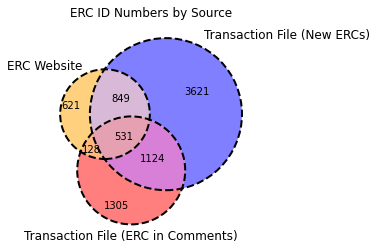

In [10]:
from math import nan

previous_erc_columns = ["previous_erc_" + str(x) for x in range(0,17)]
df_id_values = transactions_updated[previous_erc_columns].values.tolist()
df_id_values_cleaned = []
for row in df_id_values:
    new_row = [x for x in row if type(x) == str or isnan(x) == False]
    df_id_values_cleaned.extend(new_row)

#Let in_A = in ERC
in_A= set(mergedERC_group_period_fixed["ercnbr"].values.tolist())
#Let in_B = in Transaction Current
in_B = set(transactions_updated["ercnbr"])
#Let in_C = in Transaction previous
in_C = set(df_id_values_cleaned)

in_all_three = in_A.intersection(in_B, in_C)
inA_and_inB_not_inC = in_A.intersection(in_B) - in_C
inA_and_inC_not_inB = in_A.intersection(in_C) - in_B
inB_and_inC_not_inA = in_B.intersection(in_C) - in_A
only_inA = in_A - (in_B.union(in_C)  )
only_inB = in_B - (in_A.union(in_C)  )
only_inC = in_C - (in_B.union(in_A)  )



# depict venn diagram
venn3(subsets=(len(only_inA), len(only_inB), len(inA_and_inB_not_inC), len(only_inC), len(inA_and_inC_not_inB), len(inB_and_inC_not_inA), len(in_all_three)), 
      set_labels=('ERC Website', 'Transaction File (New ERCs)', 'Transaction File (ERC in Comments)'), 
      set_colors=("orange", "blue", "red"), alpha=0.5)
  
# outline of circle line style and width
venn3_circles(subsets=(len(only_inA), len(only_inB), len(inA_and_inB_not_inC), len(only_inC), len(inA_and_inC_not_inB), len(inB_and_inC_not_inA), len(in_all_three)),
              linestyle="dashed", linewidth=2)
  
# title of the venn diagram
plt.title("ERC ID Numbers by Source")
plt.show()

##  5) Creating the sub datasets based on the cases


### Case 1 : ERC numbers in ERC website 

In [23]:

Case1_object_list = []
for objects_i in mergedERC_group_period_fixed.values.tolist():
    obj_i = ERC(objects_i, 0)
    Case1_object_list.append(obj_i)


### Case 2:  ERC number only in Transaction File (New ERCs)

In [12]:

Case2_object_list = []

for object_i in df_id.values.tolist():
    if object_i[11] in only_inB:
        obj_i = ERC(object_i, 1)
        Case2_object_list.append(obj_i)

year_is = []
for object_i in Case2_object_list: 
    year_created = object_i.year_issued
    month_created = object_i.month_issued
    created_index = 12* (year_created-1989) + month_created - 1 #Index of month and year in the year_existance list below
    new_obs_year = [0 if x < created_index else 1 for x in range(0,34* 12)]   #ERC from 1989 to 2022 (34 years) and 12 months each ] 

    year_is.append(year_created)
    object_i.observed_years = new_obs_year
    

# Finding the number of ERC number in this case before 2007 
# year_is_after2007 = [x for x in year_is if x > 2007 ]
# year_is_before2008 = [x for x in year_is if x < 2008 ]

# print(len(year_is))
# print(len(year_is_after2007))
# print(len(year_is_before2008))

3621
1771
1850


### Case 3: ERC number in Transaction File (New ERCs) and comments but not in the ERC website

In [13]:
 

Case3_object_list = []
a= 0 
for object_i in transactions_updated.values.tolist():
    
    if object_i[11] in inB_and_inC_not_inA:
        a =a +1 
        obj_i = ERC(object_i, 1)
        Case3_object_list.append(obj_i)



#if this ERC number is in other object get the issue date for that object 
#Set that issue date as the end date for this object


In [14]:
Case1n2_object_list = Case2_object_list + Case1_object_list + Case3_object_list
Case1n2_object_list_prevERC = [x.get_previousERC() for x in Case1n2_object_list]

def find_indices(list_to_check, item_to_find):
    return [idx for idx, value in enumerate(list_to_check) if value == item_to_find]

#for i in case3_object_list 
#   Get the index(s) of i in case1n2
#   Use these index to get year and month
#   Use this info with issue date to update the obs_years 

for case3_obj_i in Case3_object_list:
    current_ERC = case3_obj_i.get_currentERC()
    indices = find_indices(Case1n2_object_list_prevERC, current_ERC)
    ended_index =0
    for i in indices:
        month_year = Case1n2_object_list[i].get_issued_date()
        month = month_year[0]
        year = month_year[1]
        created_index_i = 12* (year-1989) + month - 1
        if created_index_i>ended_index: ended_index = created_index_i
    
    issued_month_year = case3_obj_i.get_issued_date()
    created_index = 12* (issued_month_year[1]-1989) + issued_month_year[0] - 1
    if ended_index> created_index: 
        new_obs_year = [0 if x < created_index else 0 if x >= ended_index else 1 for x in range(0,34* 12)]
        #['yes' if v == 1 else 'no' if v == 2 else 'idle' for v in l]
    else: 
        new_obs_year = [0 if x < created_index else 1 for x in range(0,34* 12)]
    case3_obj_i.observed_years = new_obs_year
   


## 6) Merging the sub datasets to create the final dataset

In [15]:

total_object_list = Case2_object_list + Case1_object_list + Case3_object_list

import calendar
month_name = list(calendar.month_name)[1:]
month_year_list = [planet +"_"+str(sublist) for sublist in range(1989,2023) for planet in month_name ]

df_data = []
for object_i in total_object_list:
    df_data.append(object_i.get_dataframe_row()[:-9])

col_name = ["Company ID", "Company Name", "Pollutant", "ERC_number"]
col_name.extend(month_year_list[:-9])


df_2 = pd.DataFrame(df_data, columns=col_name)
df_2 = df_2.groupby(["Company ID", "Pollutant"]).sum()
df_2 = df_2[df_2.columns.tolist()[10:]]


In [18]:


filepath = Path('Amount_perPollutant_perYear.csv')  

filepath.parent.mkdir(parents=True, exist_ok=True)  

df_2.to_csv(filepath)